# Variational autoencoders
Some experiments into using them to approximate distributions with few samples.

In [70]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from keras.optimizers import Adam

from pypuffin.keras.layers import VariationalMSE
from pypuffin.keras.variational_autoencoder import SimpleDenseVAE

# A VAE with some dense layers & relu activation, targetting something using an MSE model loss.
# It has a two-dimensional latent variable space
simple_vae = SimpleDenseVAE(2, 5, 'relu', None, None, VariationalMSE, 2, 2, optimizer=Adam(1e-4))
print(simple_vae)

(1280, 2)


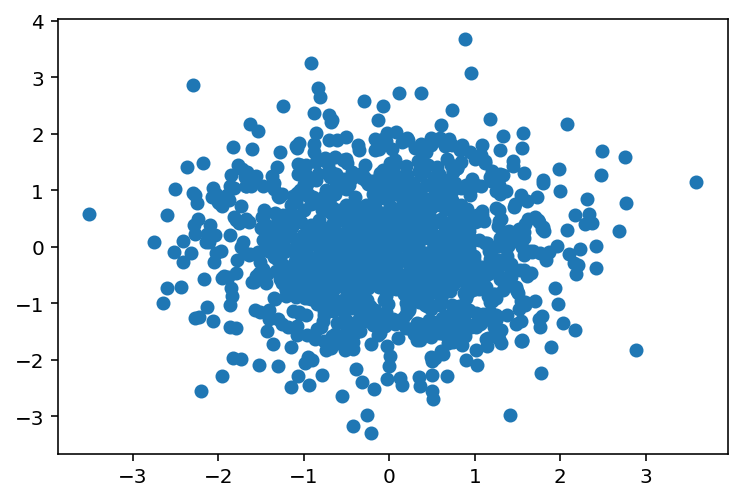

In [71]:
import numpy as np
from matplotlib import pyplot as plt

dim = 2
size = 1280
x_train = np.random.normal(size=(size, dim))
print(x_train.shape)
plt.scatter(x_train[:, 0], x_train[:, 1]);

In [75]:
vae, encoder, decoder = simple_vae.build()
history = vae.fit(x_train, epochs=10000, verbose=False, batch_size=128)

/Users/thomas/Documents/Programming/pypuffin/pypuffin/keras/variational_autoencoder.py:64: UserWarning: Output "variational_mse_17" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "variational_mse_17" during training.
  vae.compile(optimizer=self._optimizer, loss=None)


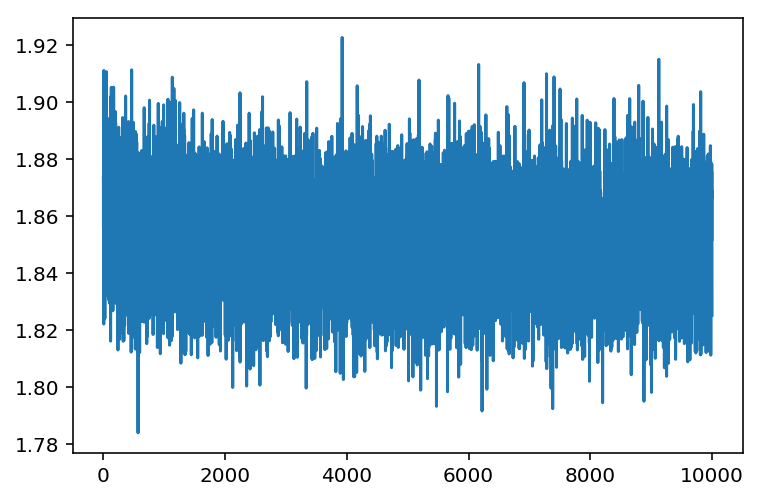

In [76]:
plt.plot(history.epoch, history.history['loss'], label='loss');

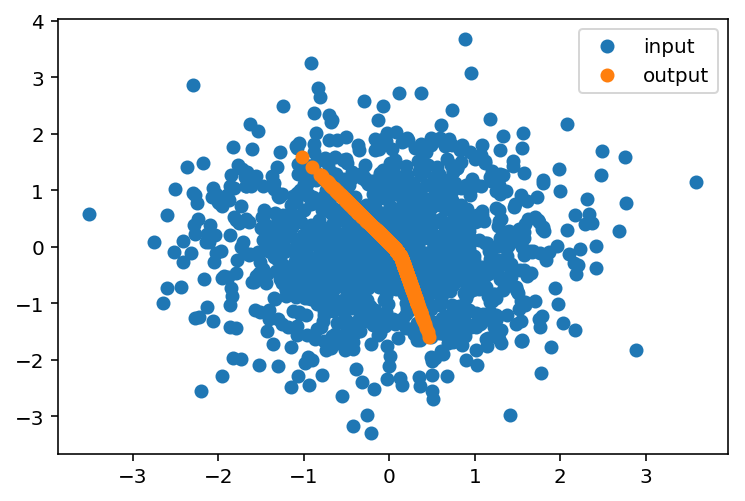

In [77]:
x_out = decoder.predict(encoder.predict(x_train))
plt.scatter(x_train[:, 0], x_train[:, 1], label='input')
plt.scatter(x_out[:, 0], x_out[:, 1], label='output')
plt.legend();